# Data Labelling
## The Triple-barrier Method

Identifying Outliers
Identifying Outliers — Part Two
Identifying Outliers — Part Three
Stylized Facts
Feature Engineering & Feature Selection
Data Transformation
Fractionally Differentiated Features
Data Labelling
Meta-labeling and Stacking

The triple-barrier method labels an observation according to the first barrier touched out of three barriers introduced in Chapter 3 of Advances in Financial Machine Learning by Marcos Prado¹. The conventional way to label the data is by using the next day (lagged) return with the fixed-time horizon method.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'
import yfinance as yf
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('AAPL', start = begin_date,
                     auto_adjust=True,#only download adjusted data
                     end= end_date) 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df
Apple_stock = get_data('AAPL', '2000-01-01', '2010-12-31')   
price = Apple_stock['close']

[*********************100%***********************]  1 of 1 completed


In [17]:
Apple_stock

,open,high,low,close,volume
Date,,,,,
2000-01-03,0.806567,0.865209,0.782053,0.860883,535796800
2000-01-04,0.832523,0.850789,0.778208,0.788302,512377600
2000-01-05,0.797915,0.850308,0.792147,0.799837,778321600
2000-01-06,0.816181,0.822910,0.730621,0.730621,767972800
2000-01-07,0.742157,0.776765,0.734466,0.765229,460734400
...,...,...,...,...,...
2010-12-23,9.997967,10.002581,9.941671,9.954899,223157200
2010-12-27,9.931828,10.011504,9.890913,9.988124,249816000
2010-12-28,10.025965,10.049038,9.999817,10.012430,175924000


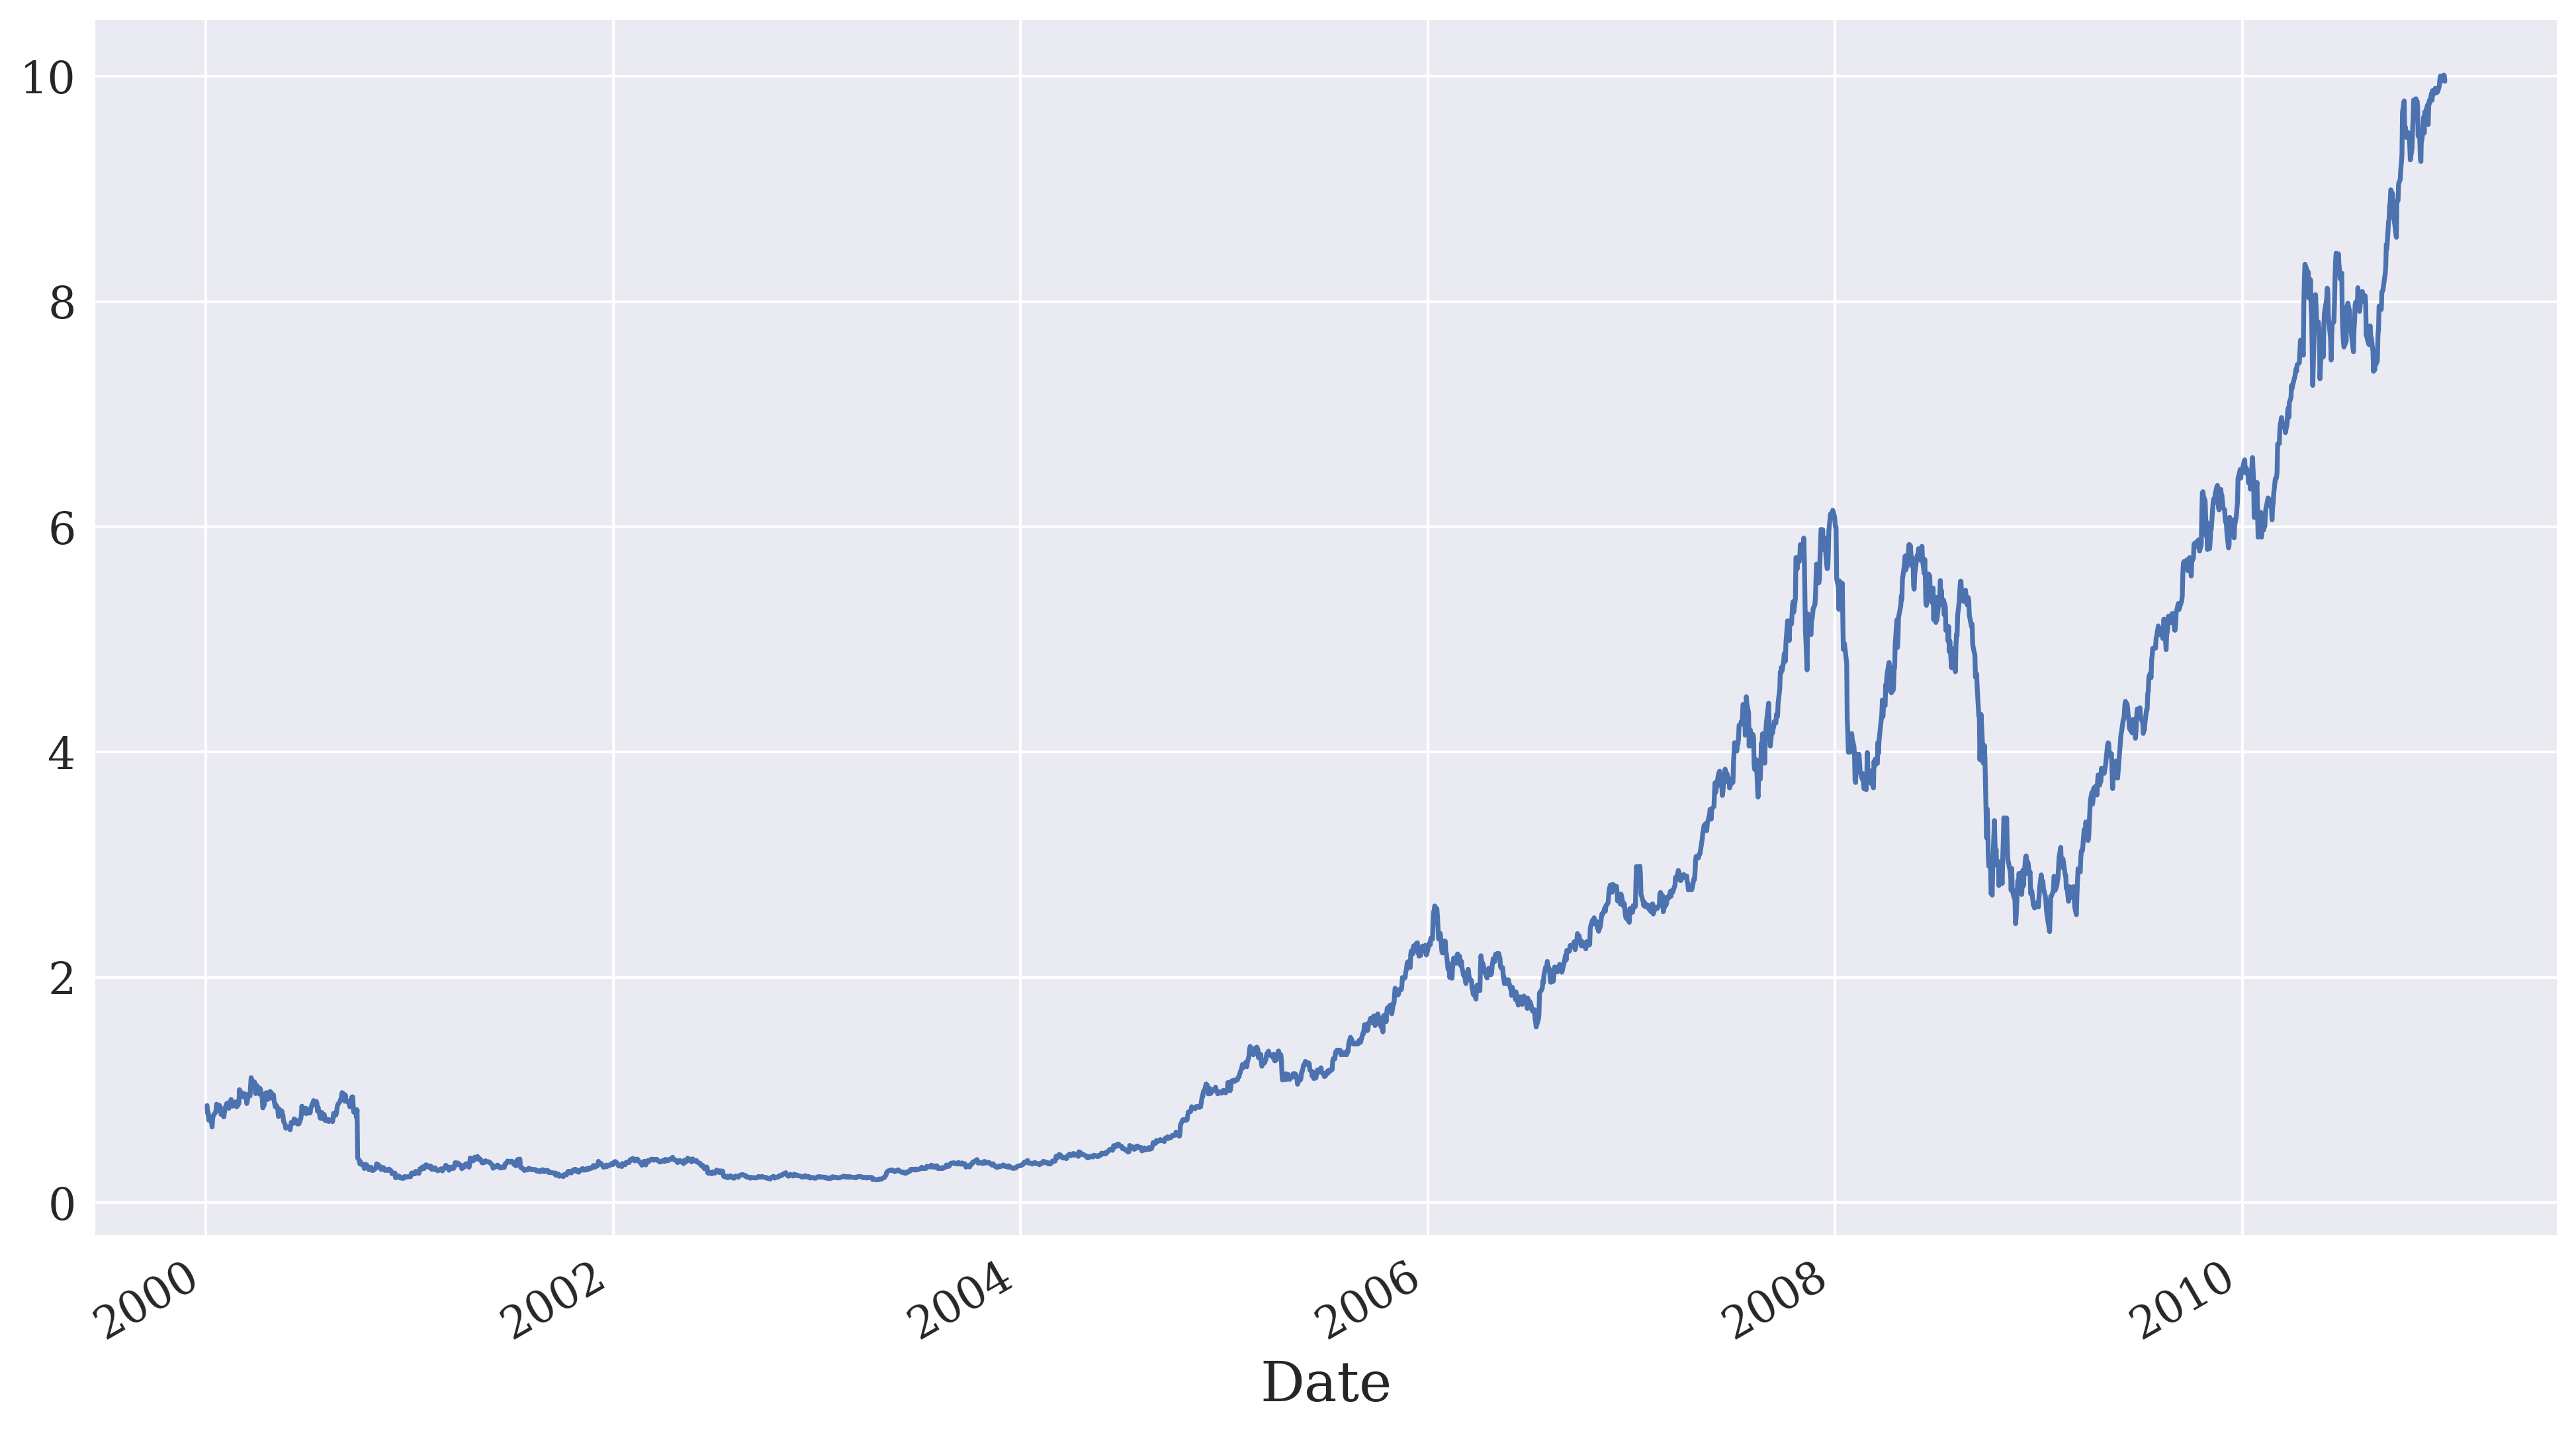

In [14]:
price.plot()

In [6]:
def getDailyVol(close,span0=100):
    # daily vol, reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]
    a = df0 -1 #using a variable to avoid the error message.
    df0=pd.Series(close.index[a], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 
    # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

In [15]:
#df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
#pd.Series(df0).value_counts()
df0=price.index.searchsorted(price.index-pd.Timedelta(days=1))
pd.Series(df0).value_counts()

0       2
2582    2
2675    2
527     2
628     2
       ..
2378    1
331     1
2382    1
335     1
2048    1
Length: 2189, dtype: int64

In [12]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)
df0

Date
2000-01-05    0.069963
2000-01-06    0.057891
2000-01-07    0.069639
2000-01-10    0.058802
2000-01-11    0.052832
                ...   
2010-12-23    0.007877
2010-12-27    0.007516
2010-12-28    0.007154
2010-12-29    0.006837
2010-12-30    0.006787
Name: close, Length: 2764, dtype: float64

In [36]:
def get_atr(stock, win=14):
    
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(stock.high.rolling(win, min_periods=win).mean())
    low = pd.Series(stock.low.rolling(win, min_periods=win).mean())
    close = pd.Series(stock.close.rolling(win, min_periods=win).mean())    
          
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                  np.abs(high[i] - close[i]), \
                  np.abs(low[i] - close[i])], \
                  axis=0)
        atr_df[i] = tr.sum() / win
     
    return  atr_df
atr_df = get_atr(Apple_stock, 14)
atr_df

<ipython-input-36-f214cbb14c18>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  atr_df = pd.Series(index=stock.index)


Date
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
                ...   
2010-12-23    0.007316
2010-12-27    0.007317
2010-12-28    0.006647
2010-12-29    0.006245
2010-12-30    0.006085
Length: 2766, dtype: float64

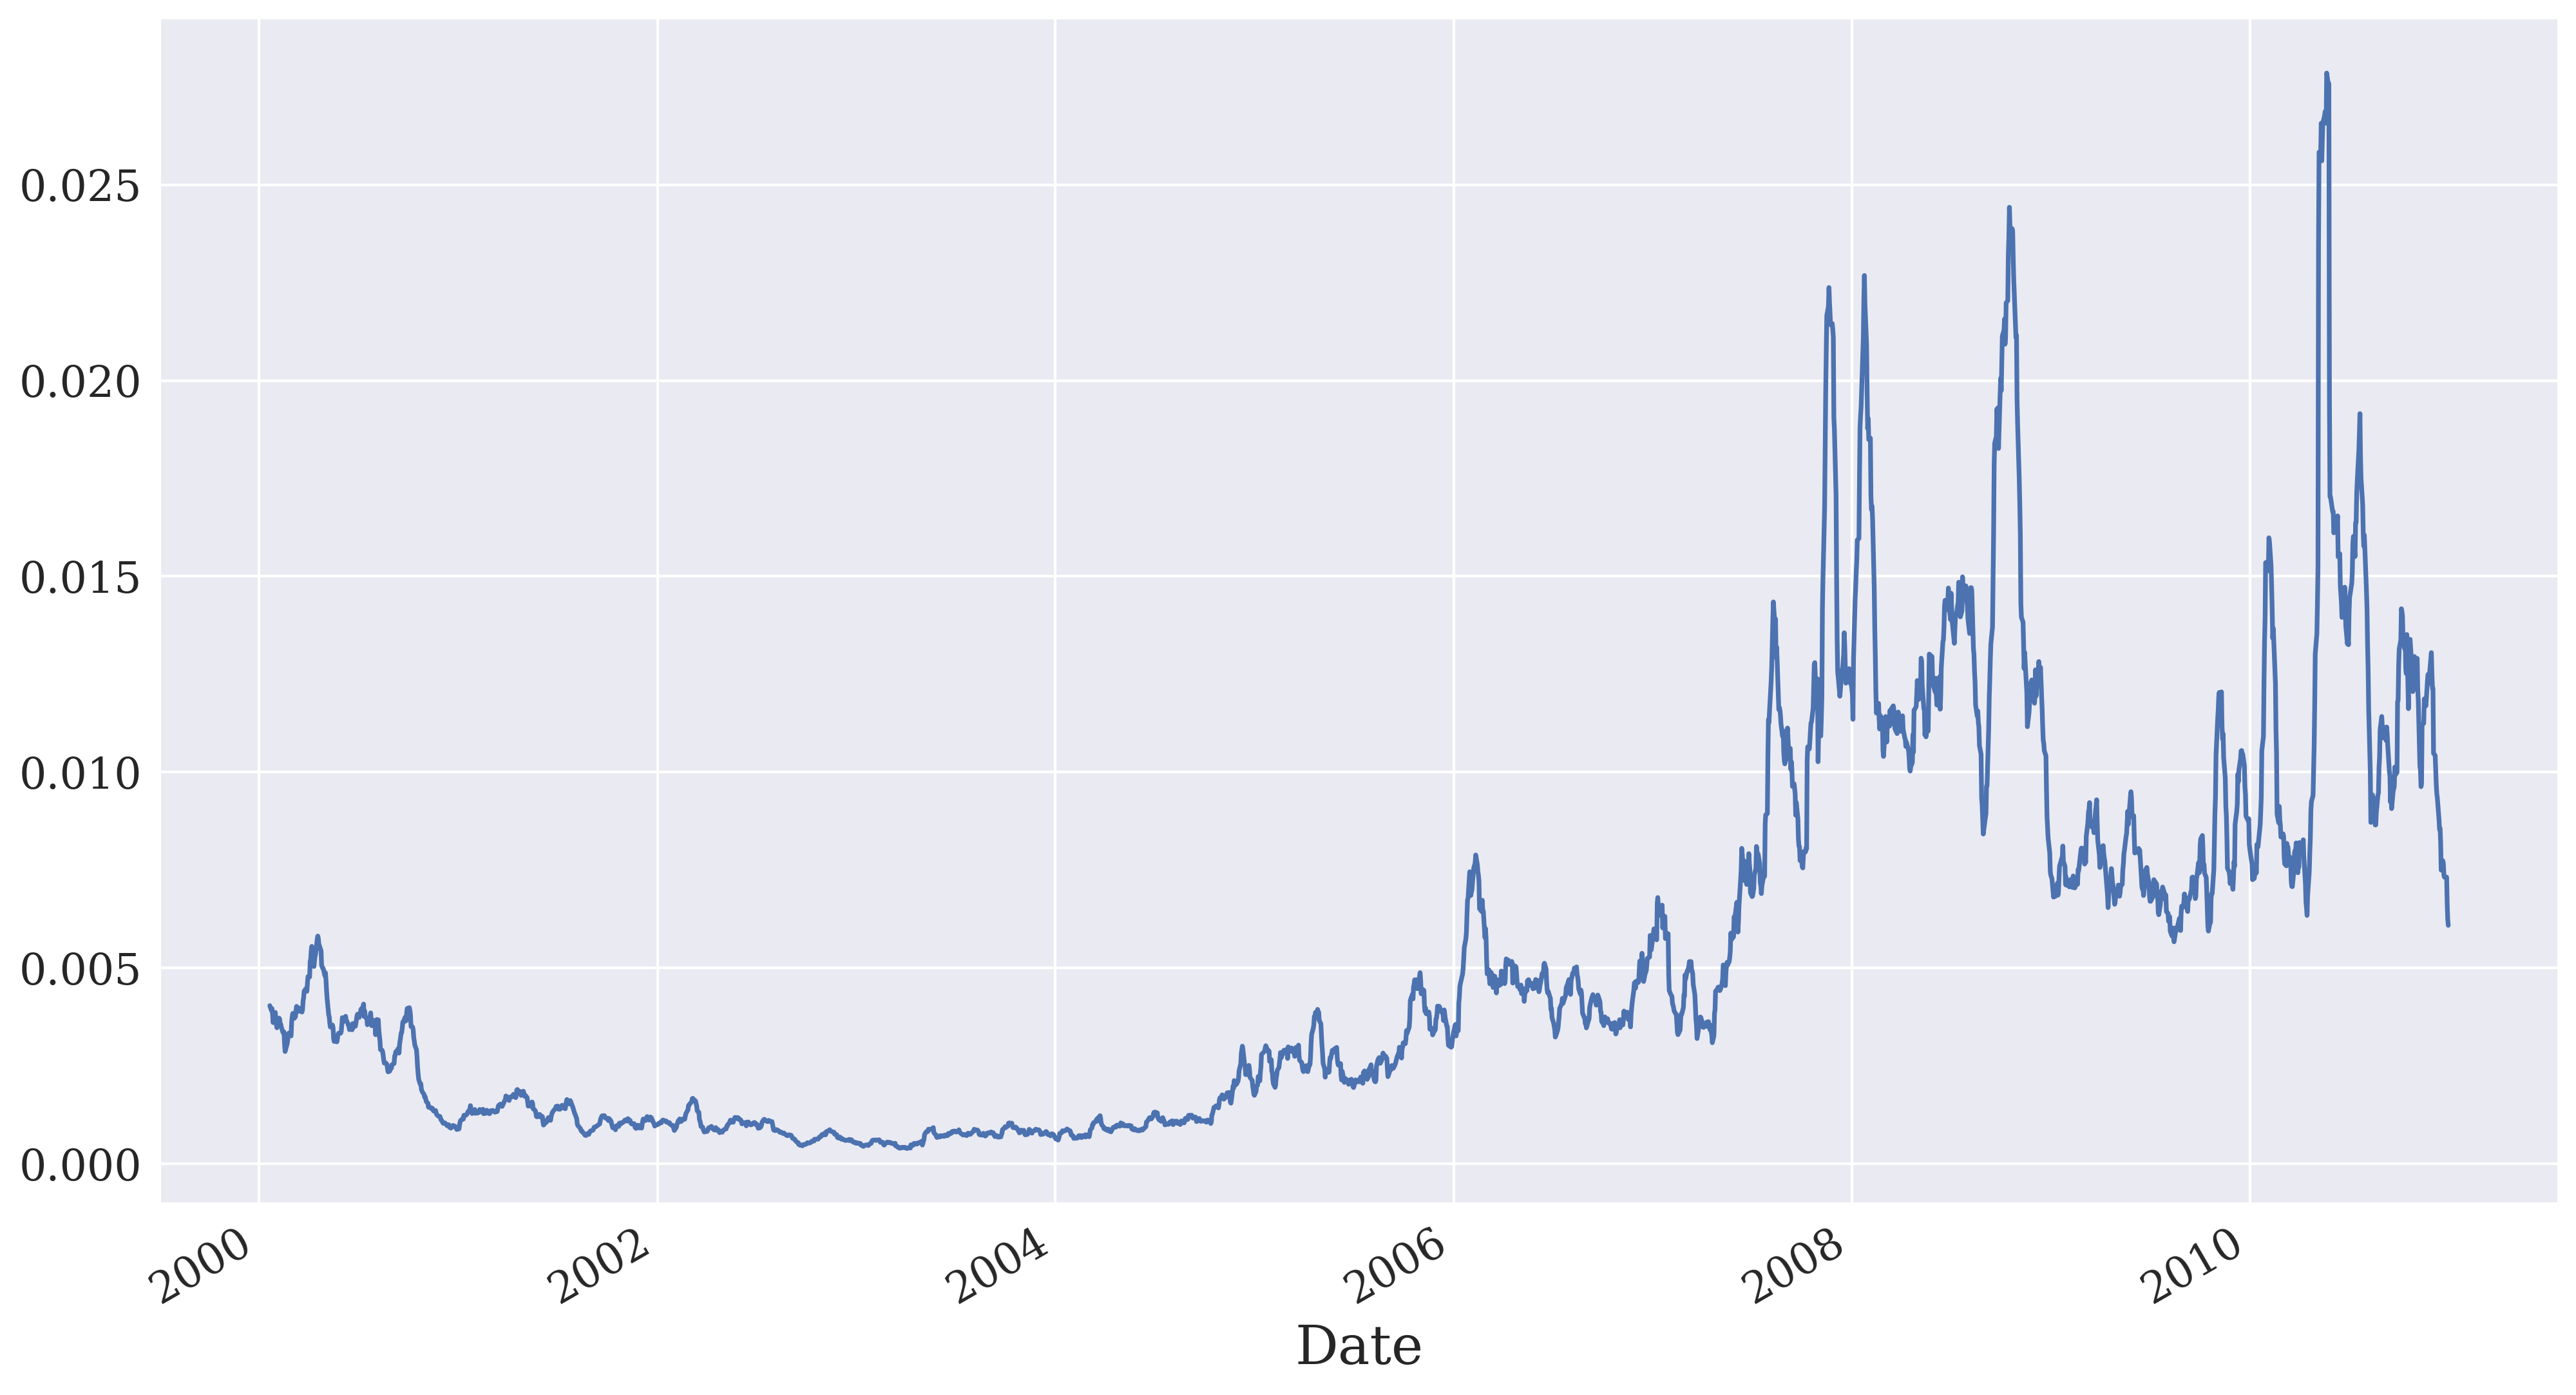

In [37]:
atr_df.plot()

In [38]:
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
#allign the index
prices = price[daily_volatility.index]

In [40]:
def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price','vert_barrier','top_barrier', 'bottom_barrier']] = days_passed, prices.loc[day], vert_barrier, top_barrier, bottom_barrier
    return barriers

In [42]:
barriers = get_3_barriers()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier
Date,,,,,
2000-01-05,1,0.799837,2000-01-21 00:00:00,0.911756,0.687919
2000-01-06,2,0.730621,2000-01-24 00:00:00,0.815213,0.646028
2000-01-07,3,0.765229,2000-01-25 00:00:00,0.871809,0.658649
2000-01-10,4,0.751771,2000-01-26 00:00:00,0.840181,0.66336
2000-01-11,5,0.713317,2000-01-27 00:00:00,0.788688,0.637945
...,...,...,...,...,...
2010-12-23,2760,9.9549,NaN,10.1117,9.79807
2010-12-27,2761,9.98812,NaN,10.1383,9.83799
2010-12-28,2762,10.0124,NaN,10.1557,9.86918


In [43]:
barriers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2000-01-05 to 2010-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   days_passed     2764 non-null   object
 1   price           2764 non-null   object
 2   vert_barrier    2753 non-null   object
 3   top_barrier     2764 non-null   object
 4   bottom_barrier  2764 non-null   object
dtypes: object(5)
memory usage: 209.6+ KB


In [44]:
barriers['out'] = None
barriers.head()

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
Date,,,,,,
2000-01-05,1,0.799837,2000-01-21 00:00:00,0.911756,0.687919,None
2000-01-06,2,0.730621,2000-01-24 00:00:00,0.815213,0.646028,None
2000-01-07,3,0.765229,2000-01-25 00:00:00,0.871809,0.658649,None
2000-01-10,4,0.751771,2000-01-26 00:00:00,0.840181,0.66336,None
2000-01-11,5,0.713317,2000-01-27 00:00:00,0.788688,0.637945,None


In [48]:
def get_labels():
    '''
    start: first day of the window
    end:last day of the window
    price_initial: first day stock price
    price_final:last day stock price
    top_barrier: profit taking limit
    bottom_barrier:stop loss limt
    condition_pt:top_barrier touching conditon
    condition_sl:bottom_barrier touching conditon
    '''
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
             top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
             bottom_barrier).any()
            #assign the labels
            if condition_pt: 
                barriers['out'][i] = 1
            elif condition_sl: 
                barriers['out'][i] = -1    
            else: 
                barriers['out'][i] = max(
                          [(price_final - price_initial)/ 
                           (top_barrier - price_initial), \
                           (price_final - price_initial)/ \
                           (price_initial - bottom_barrier)],\
                            key=abs)
    return
get_labels()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
Date,,,,,,
2000-01-05,1,0.799837,2000-01-21 00:00:00,0.911756,0.687919,-1
2000-01-06,2,0.730621,2000-01-24 00:00:00,0.815213,0.646028,1
2000-01-07,3,0.765229,2000-01-25 00:00:00,0.871809,0.658649,1
2000-01-10,4,0.751771,2000-01-26 00:00:00,0.840181,0.66336,1
2000-01-11,5,0.713317,2000-01-27 00:00:00,0.788688,0.637945,1
...,...,...,...,...,...,...
2010-12-23,2760,9.9549,NaN,10.1117,9.79807,None
2010-12-27,2761,9.98812,NaN,10.1383,9.83799,None
2010-12-28,2762,10.0124,NaN,10.1557,9.86918,None


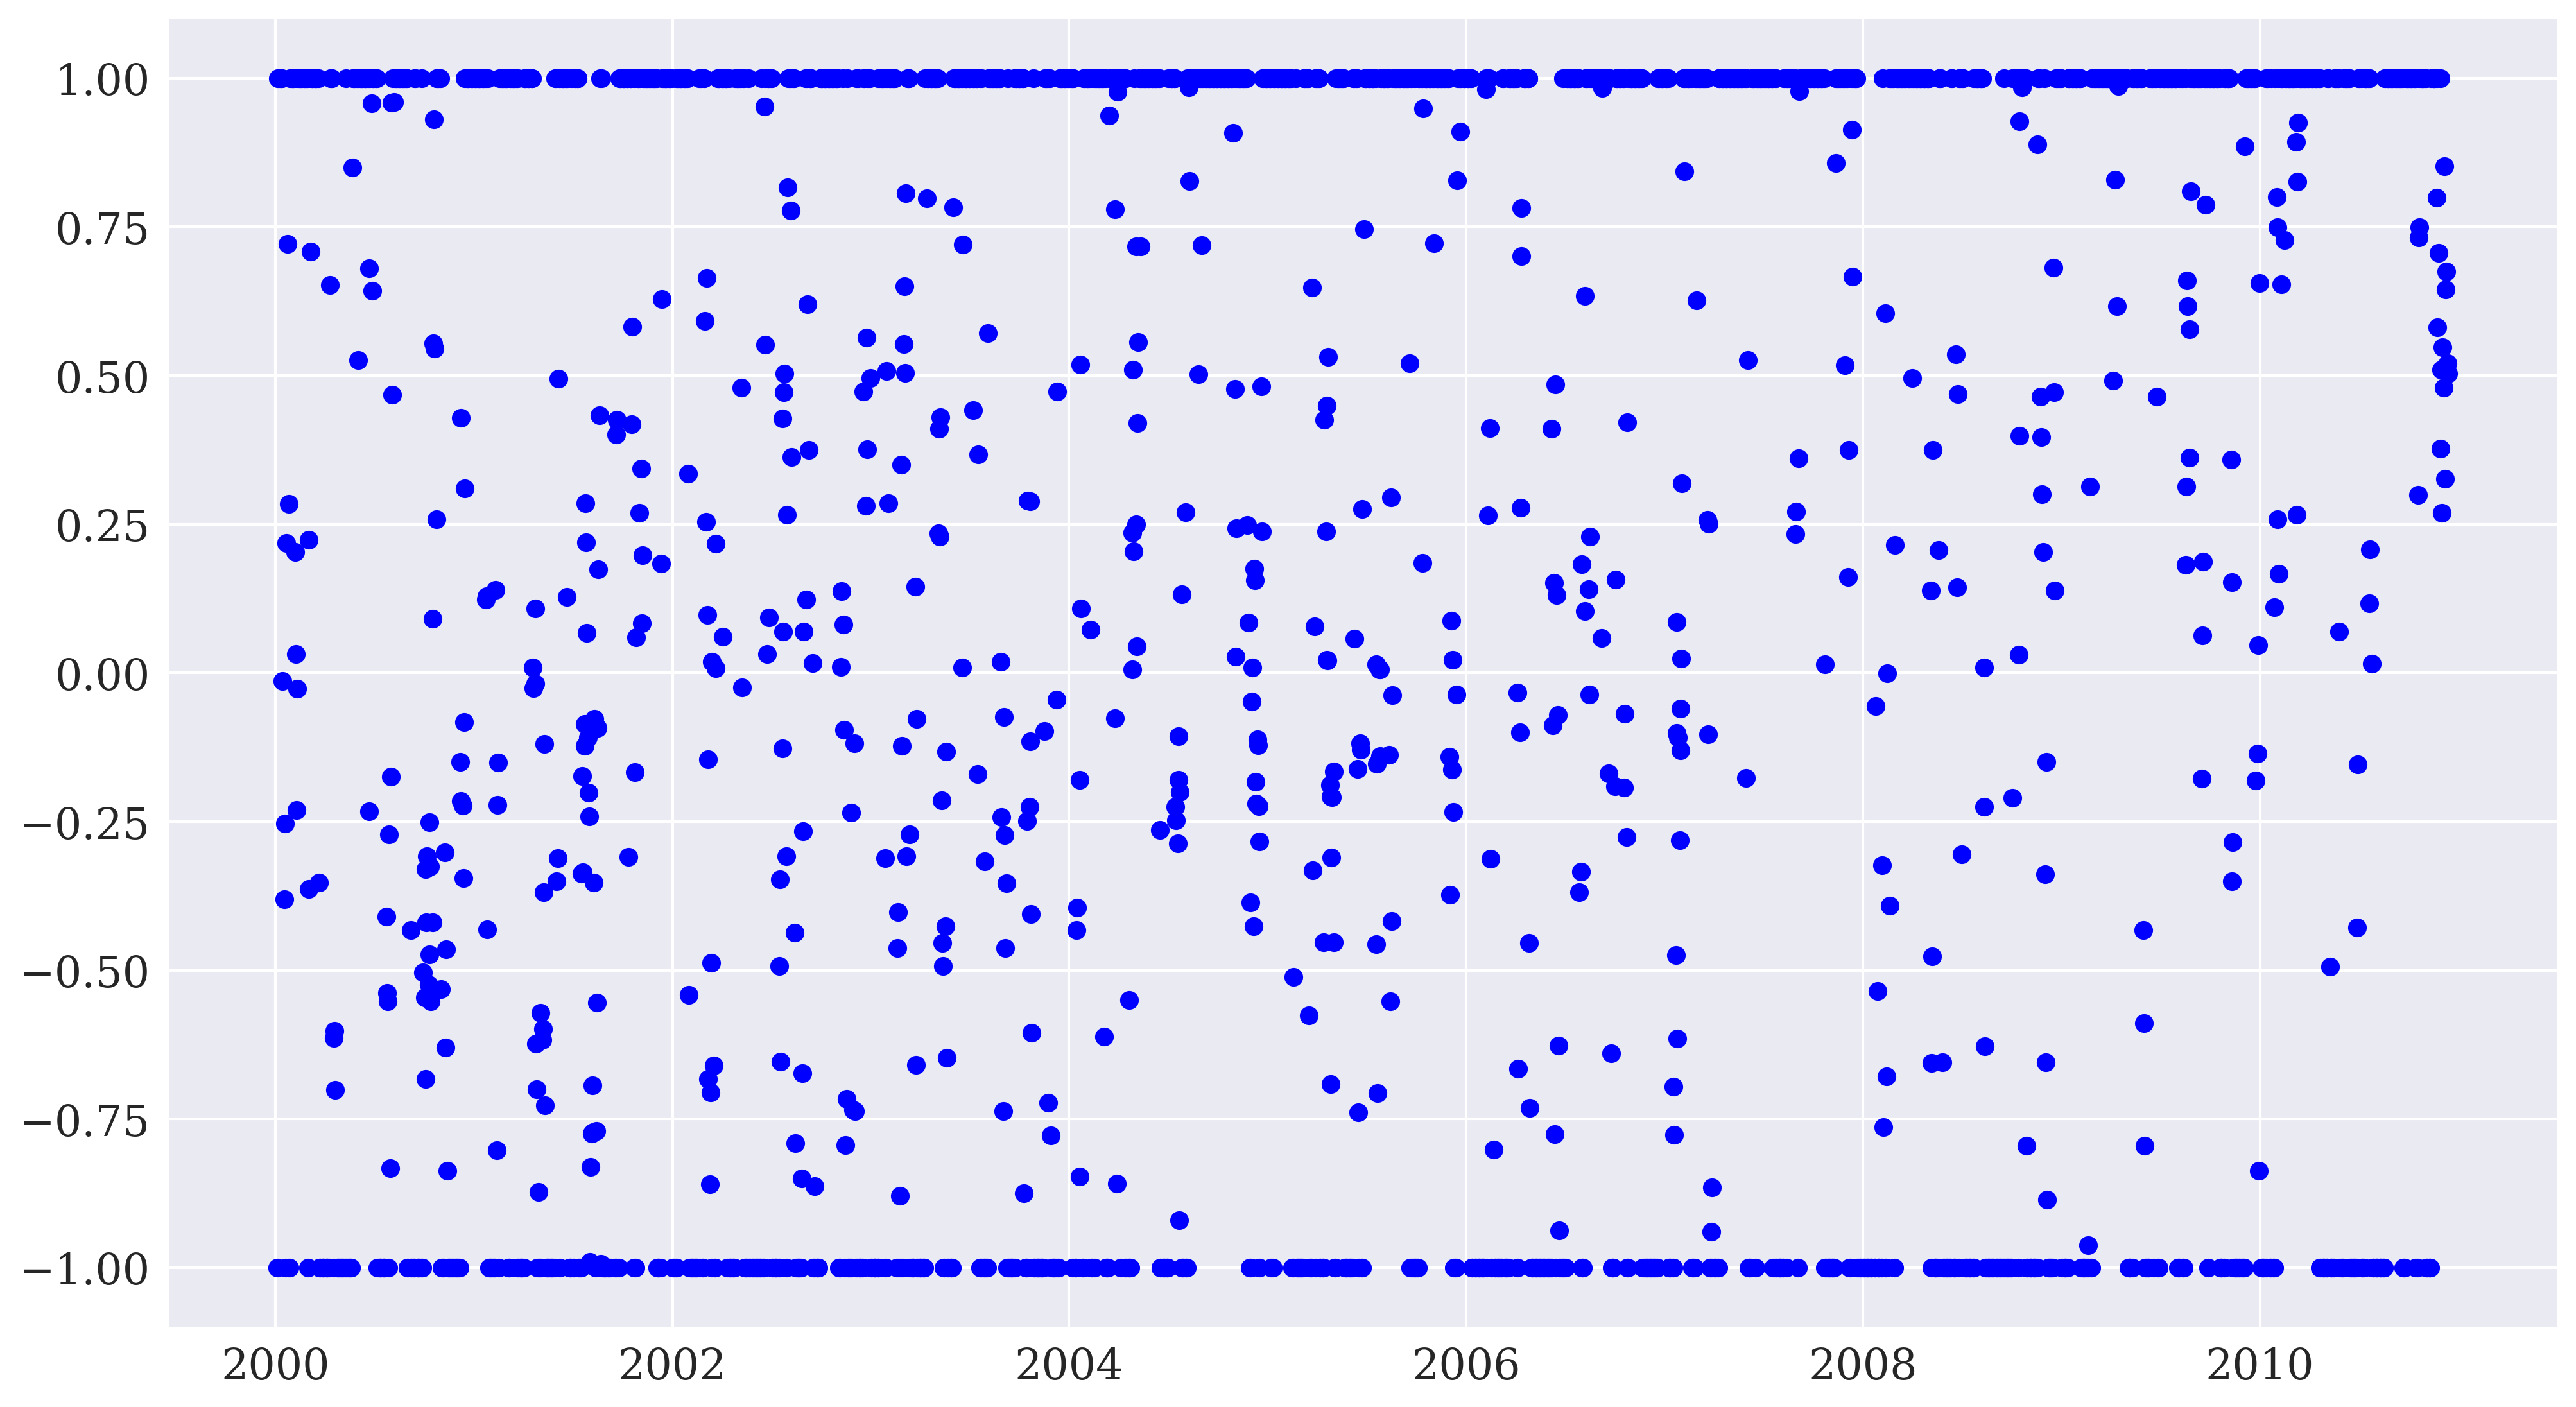

In [49]:
plt.plot(barriers.out,'bo')

In [50]:
barriers.out.value_counts()

 1.000000    1386
-1.000000     838
-0.193072       1
-0.627052       1
 0.349962       1
             ... 
 0.681527       1
-0.615133       1
-0.352485       1
-0.119468       1
 0.218121       1
Name: out, Length: 531, dtype: int64

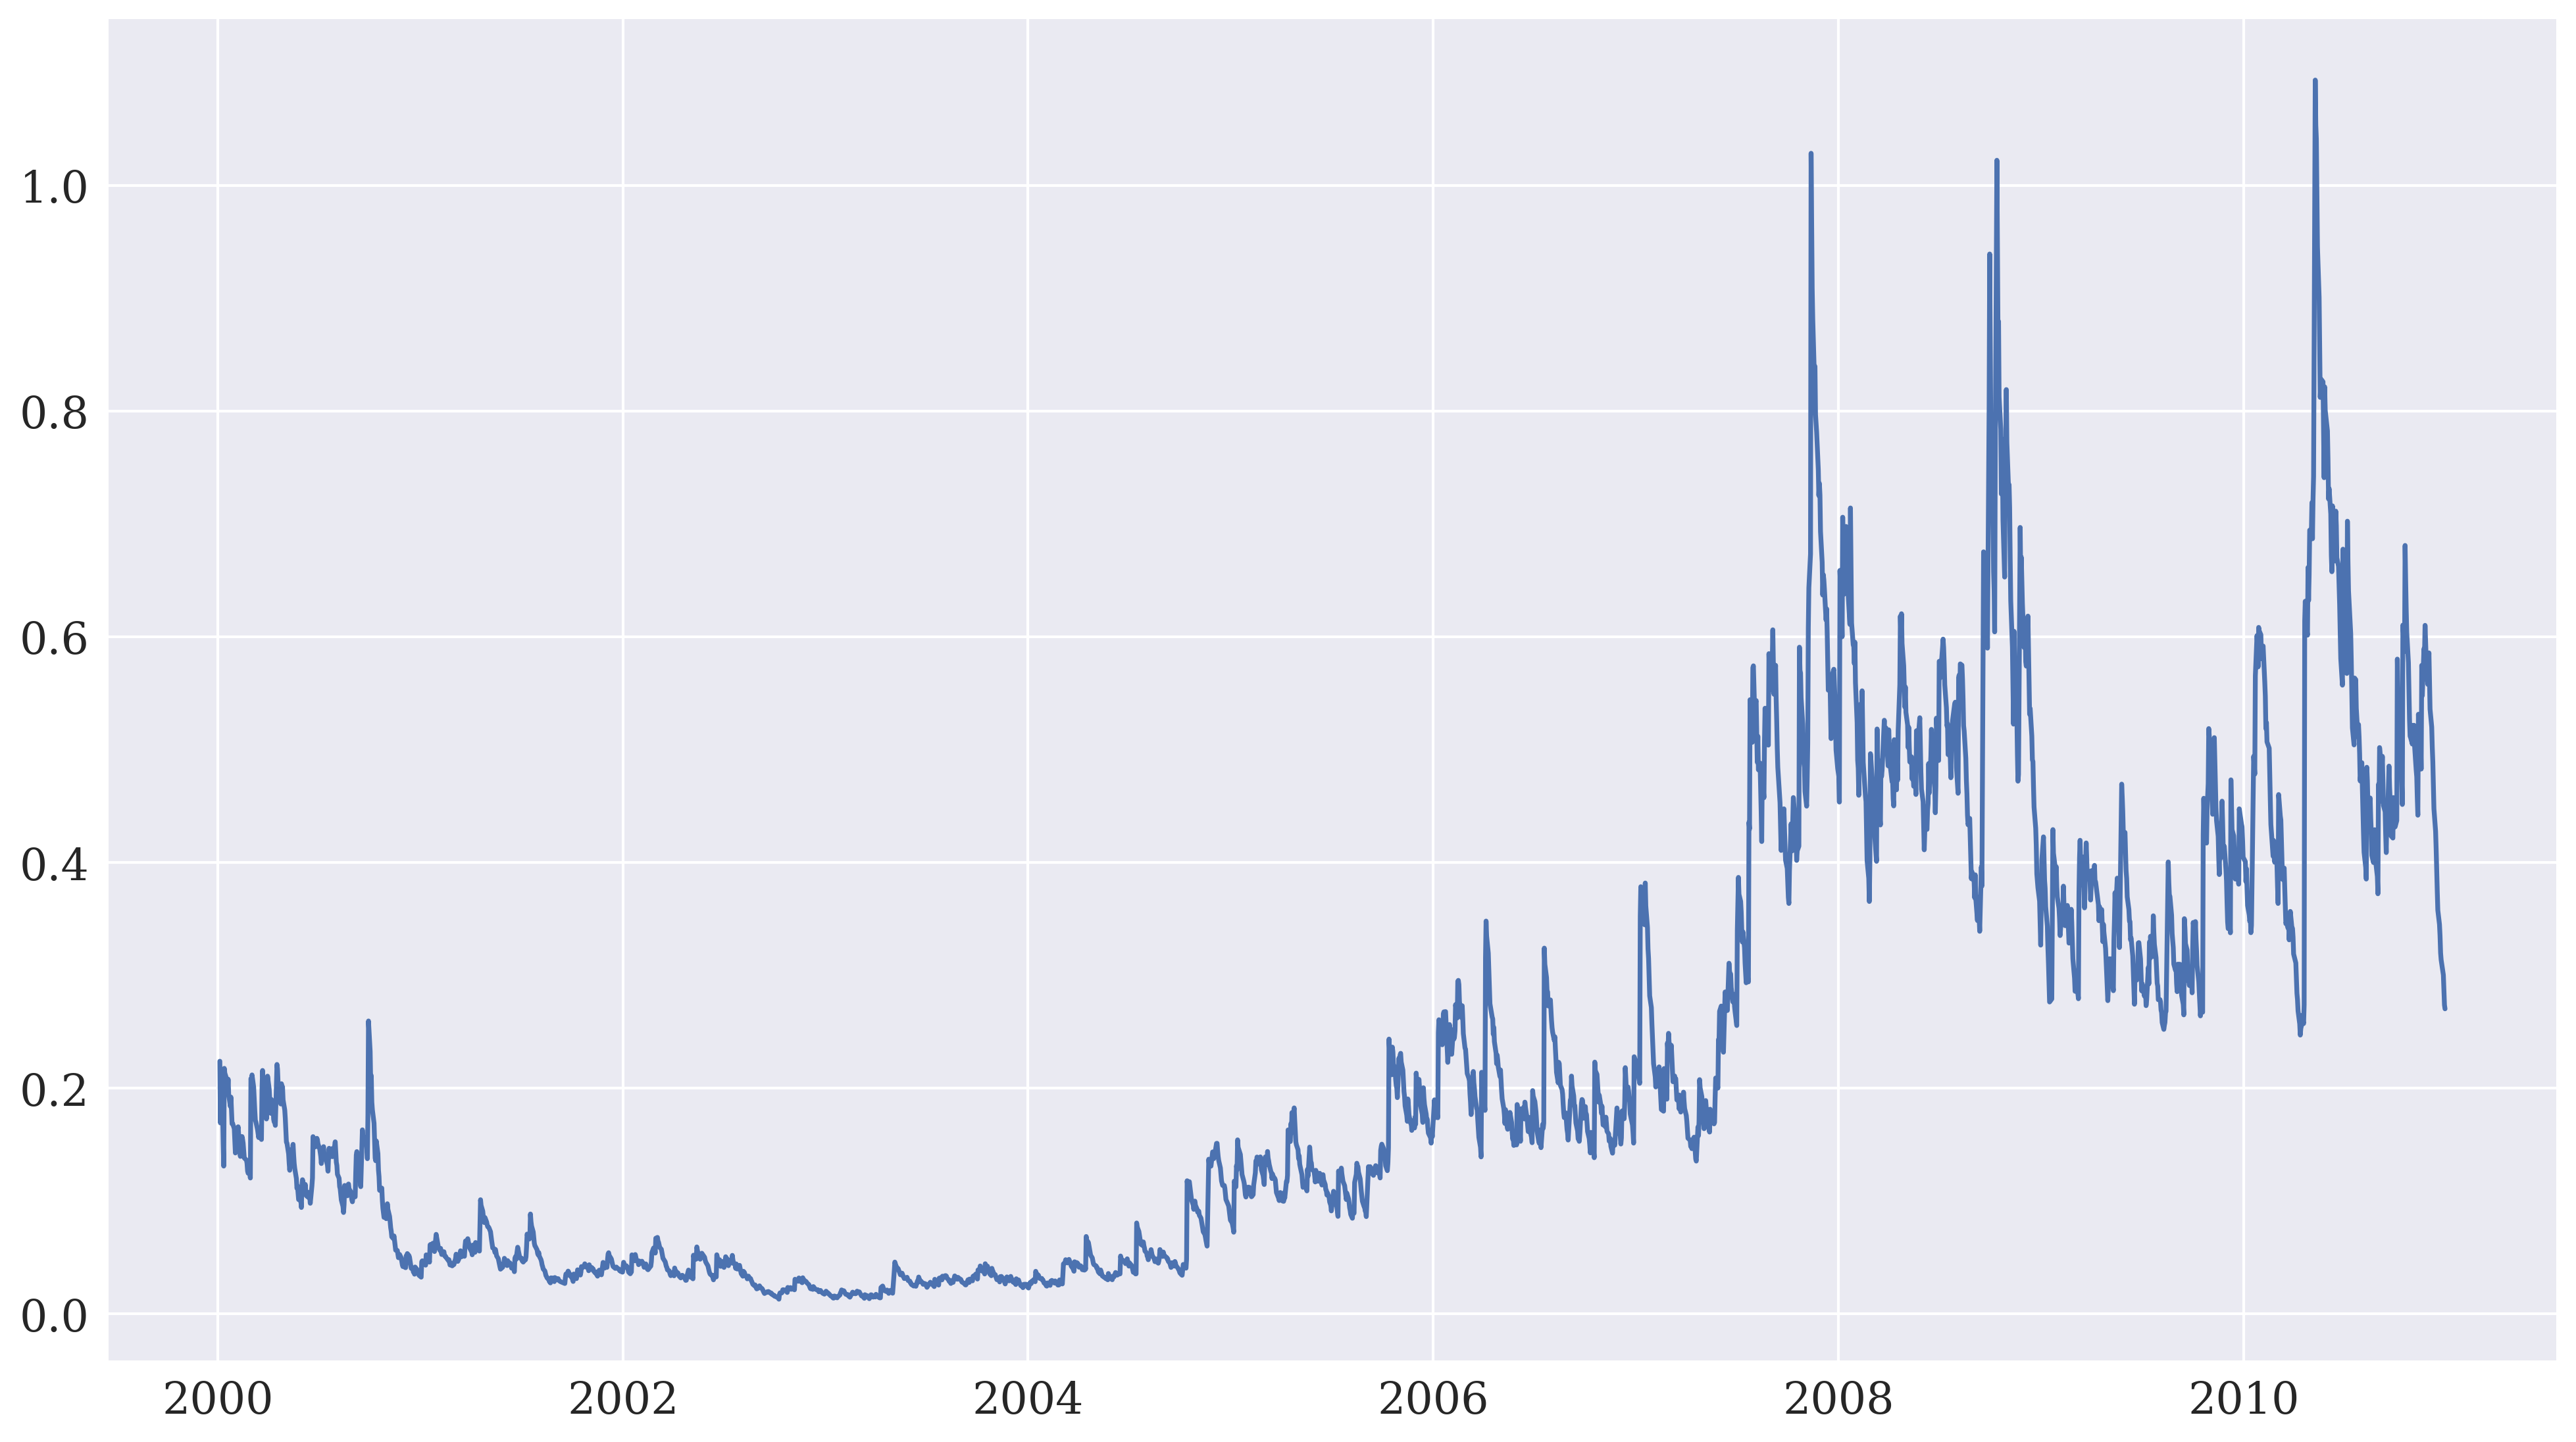

In [66]:
plt.plot(barriers.top_barrier-barriers.bottom_barrier)
#plt.plot(barriers.bottom_barrier)

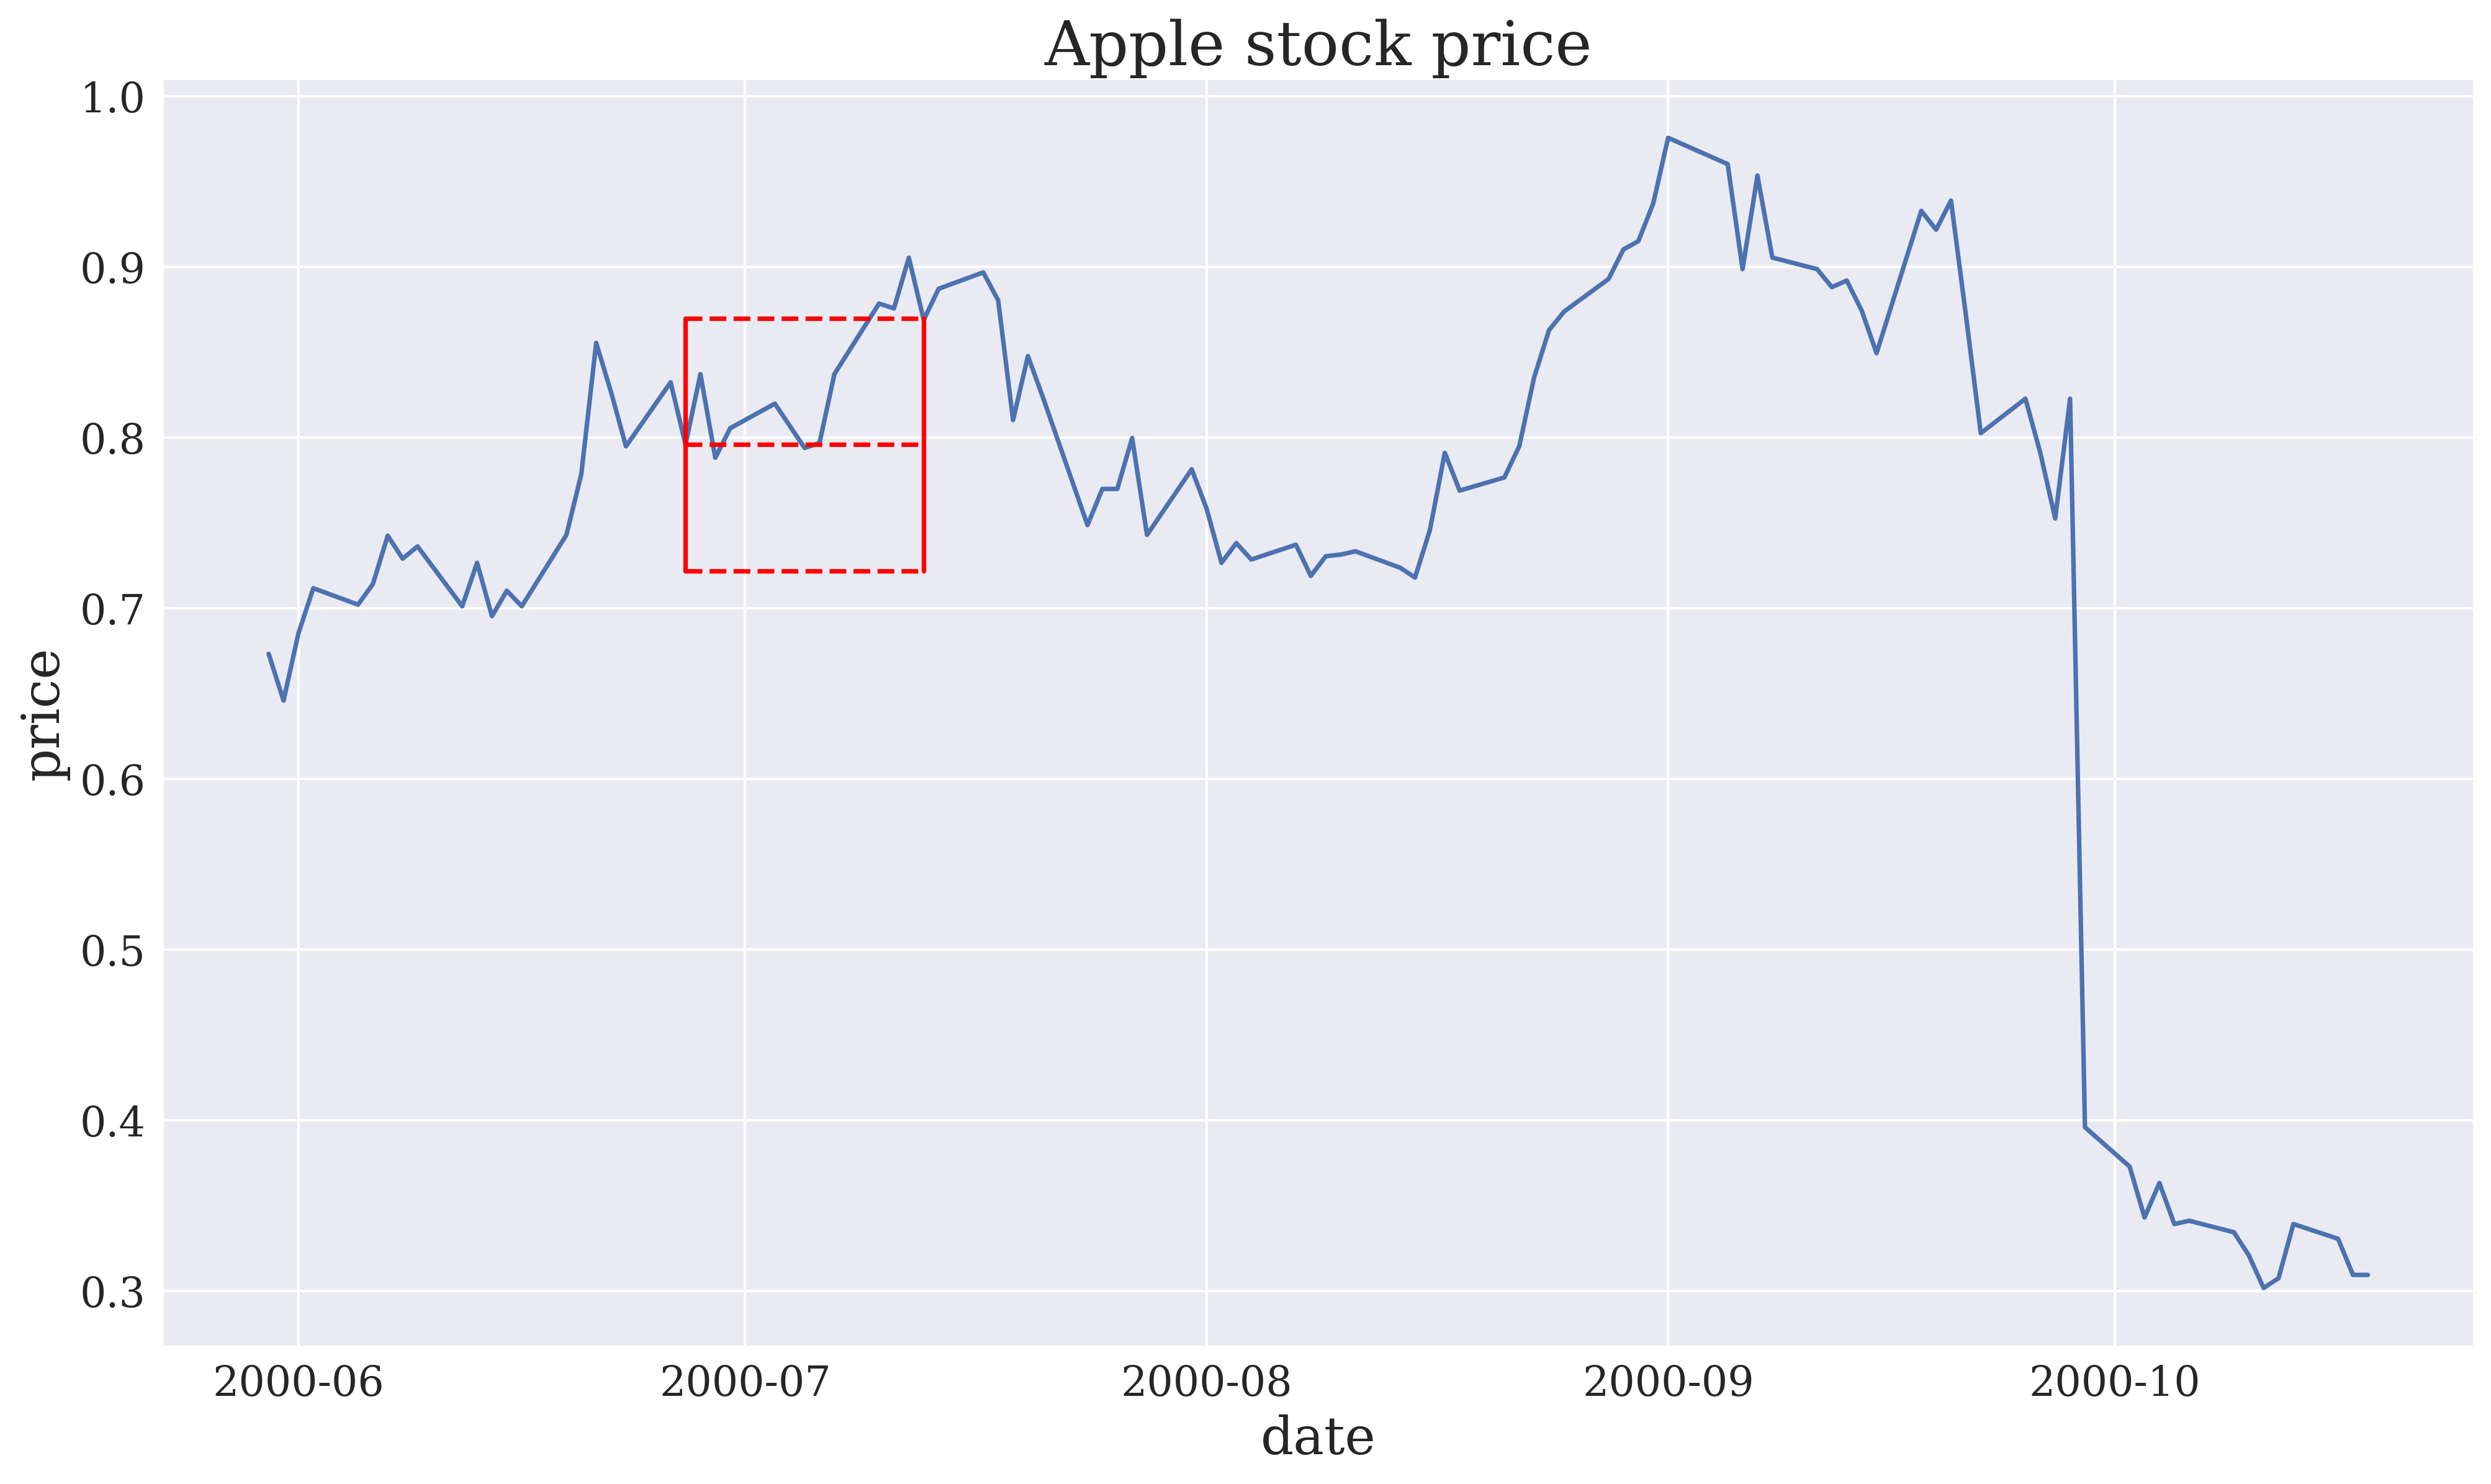

In [51]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 200])
start = barriers.index[120]
end = barriers.vert_barrier[120]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

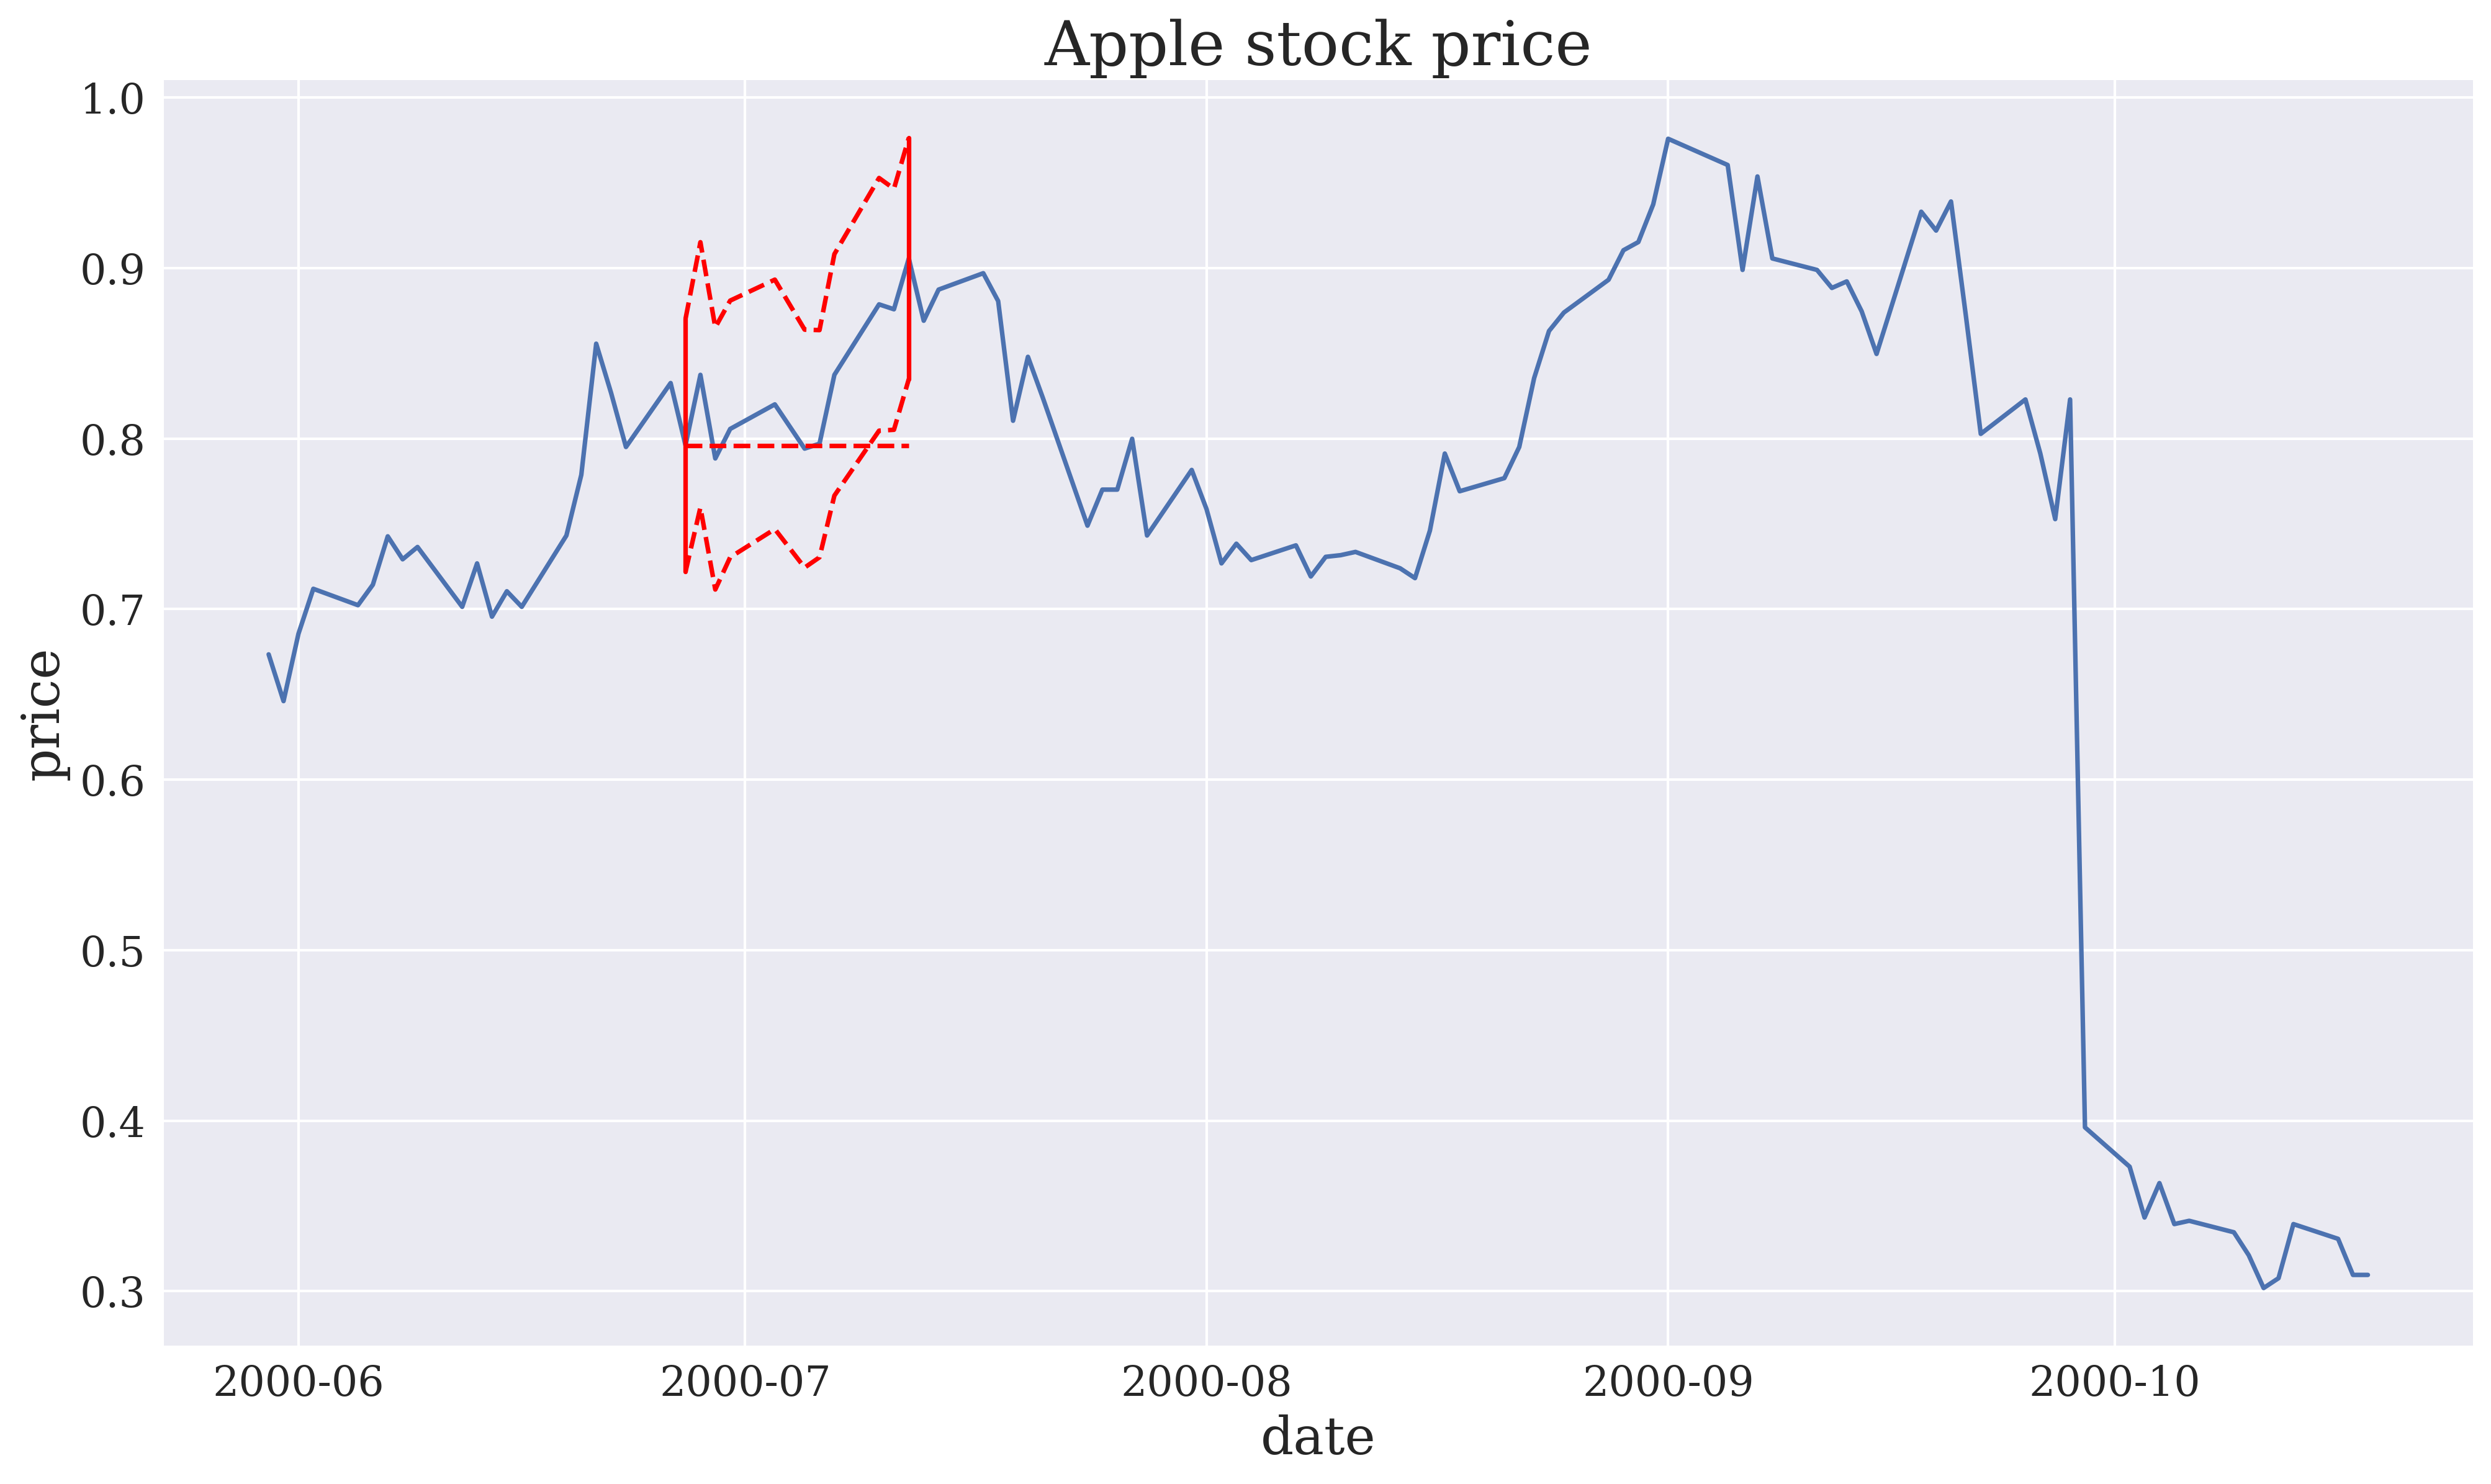

In [52]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 200])
start = barriers.index[120]
end = barriers.index[120+t_final]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot(barriers.index[120:120+t_final+1], barriers.top_barrier[start:end], 'r--');
ax.plot(barriers.index[120:120+t_final+1], barriers.bottom_barrier[start:end], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [barriers.bottom_barrier[end], barriers.top_barrier[end]], 'r-');

[*********************100%***********************]  1 of 1 completed


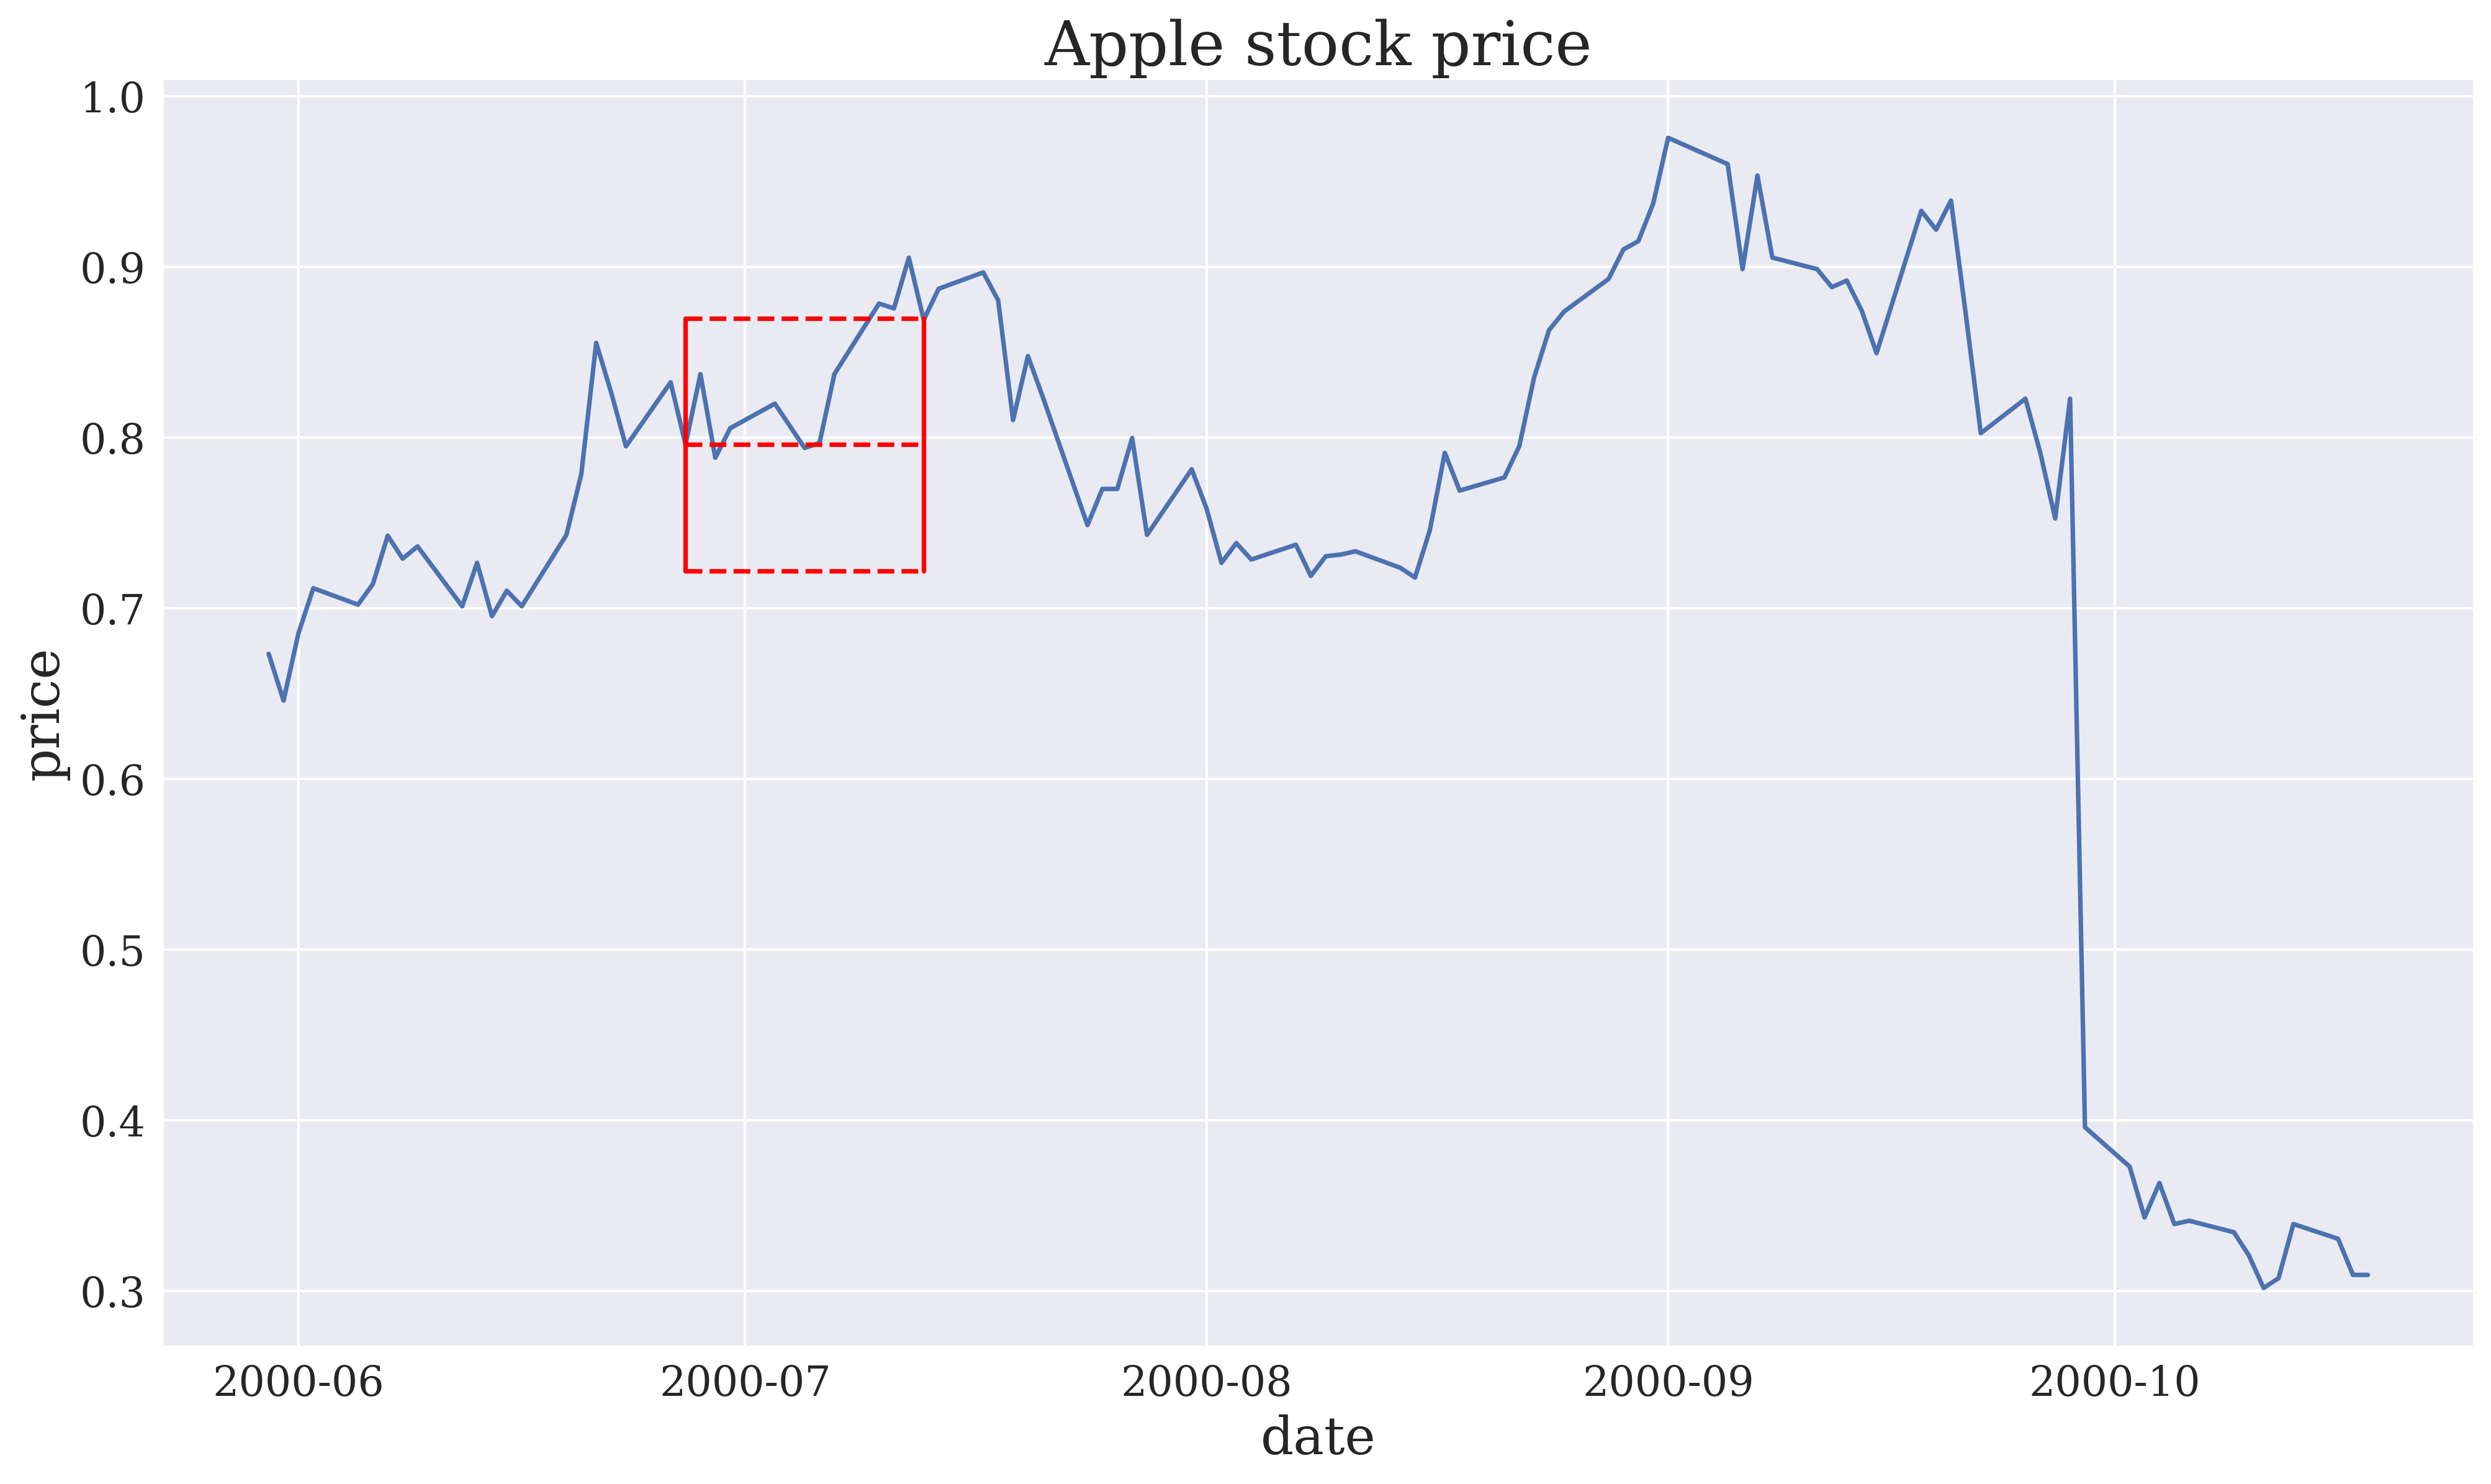

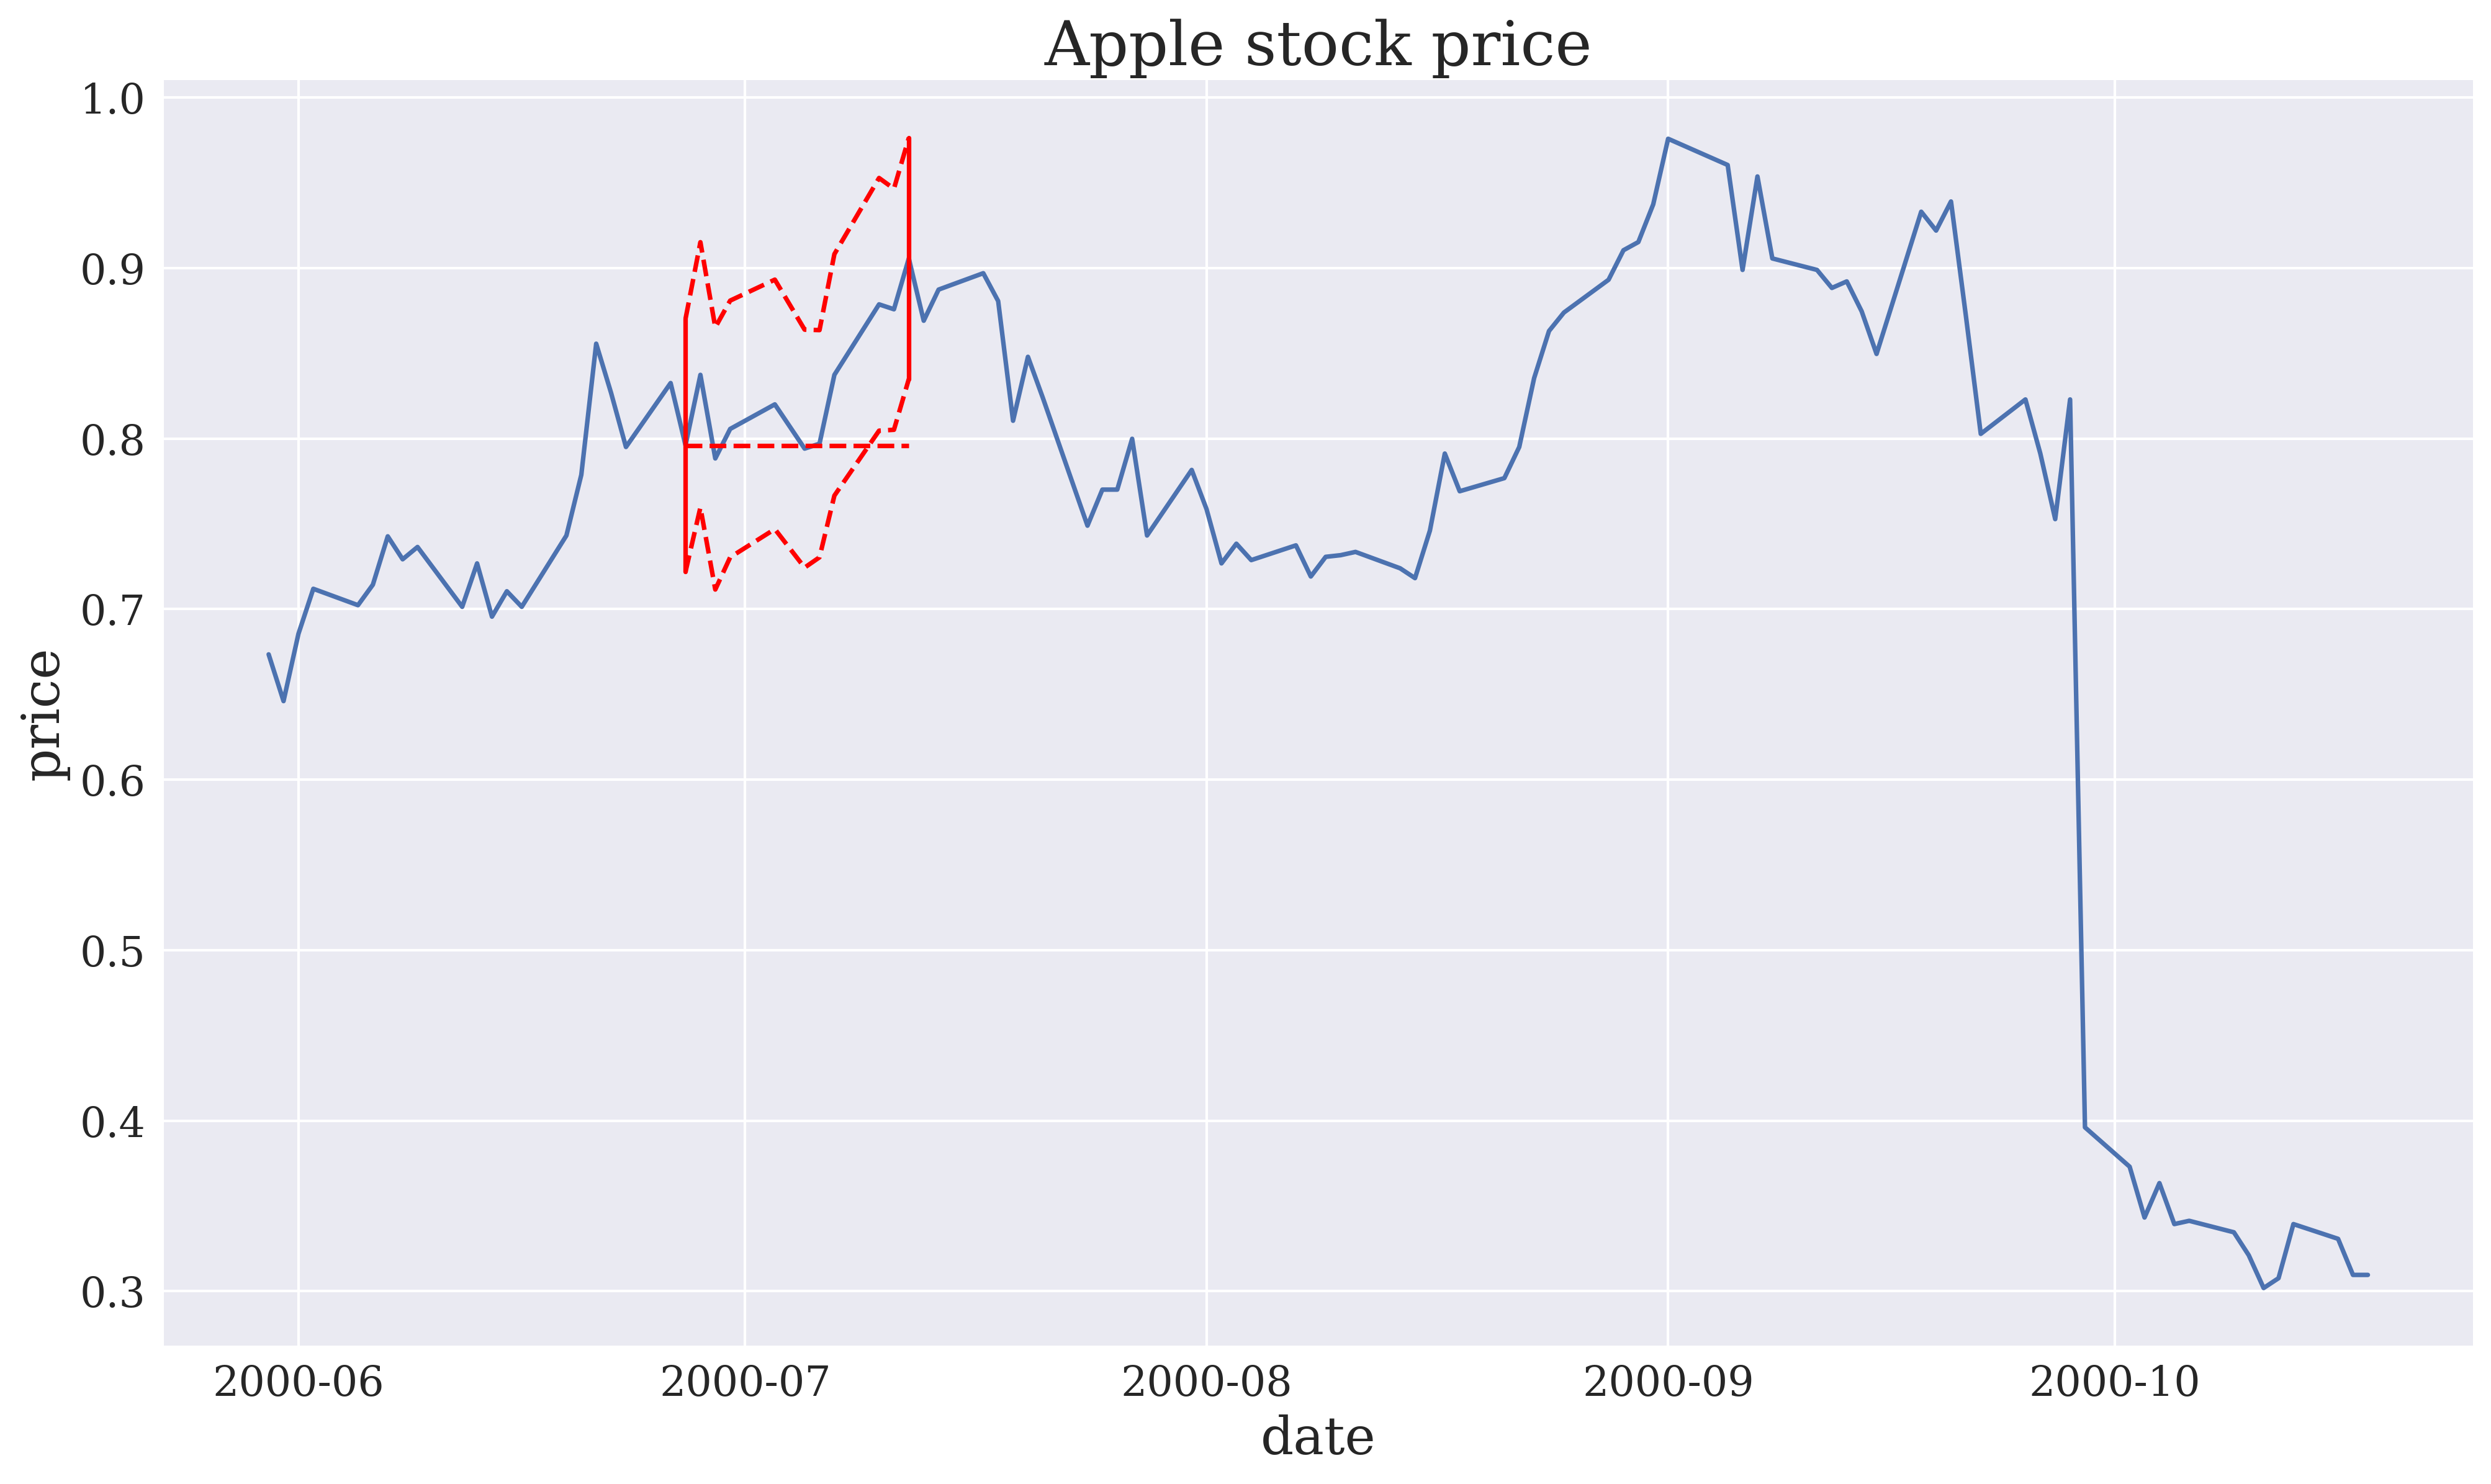

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

import yfinance as yf

def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('AAPL', start = begin_date,
                     auto_adjust=True,#only download adjusted data
                     end= end_date) 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df

Apple_stock = get_data('AAPL', '2000-01-01', '2010-12-31')   
price = Apple_stock['close']

def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

df0 = get_Daily_Volatility(price)

def get_atr(stock, win=14):
    
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(Apple_stock.high.rolling( \
                     win, min_periods=win))
    low = pd.Series(Apple_stock.low.rolling( \
                    win, min_periods=win))
    close = pd.Series(Apple_stock.close.rolling( \
                      win, min_periods=win))    
          
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                  np.abs(high[i] - close[i]), \
                  np.abs(low[i] - close[i])], \
                  axis=0)
    atr_df[i] = tr.sum() / win
     
    return  atr_df

#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    return barriers

def get_labels():
    '''
    start: first day of the window
    end:last day of the window
    price_initial: first day stock price
    price_final:last day stock price
    top_barrier: profit taking limit
    bottom_barrier:stop loss limt
    condition_pt:top_barrier touching conditon
    condition_sl:bottom_barrier touching conditon
    '''
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
            top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
            bottom_barrier).any()
            #assign the labels
            if condition_pt: 
                barriers['out'][i] = 1
            elif condition_sl: 
                barriers['out'][i] = -1    
            else: 
                barriers['out'][i] = max(
                [(price_final - price_initial)/ 
                (top_barrier - price_initial), \
                (price_final - price_initial)/ \
                (price_initial - bottom_barrier)],\
                key=abs)
    return

get_labels()
barriers
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 200])
start = barriers.index[120]
end = barriers.vert_barrier[120]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');
#dynamic graph
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 200])
start = barriers.index[120]
end = barriers.index[120+t_final]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot(barriers.index[120:120+t_final+1], barriers.top_barrier[start:end], 'r--');
ax.plot(barriers.index[120:120+t_final+1], barriers.bottom_barrier[start:end], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [barriers.bottom_barrier[end], barriers.top_barrier[end]], 'r-');